# Fine-tuning a Vision Transformer

By training the model from scratch, we have observed that the training and test accuracy were really low (around 0.4).
Since both the training and test error are high, we can assume that the model is underfitting. This makes perfectly sense, in fact we are training our model with similar parameters to the original one but the batch size is much lower due to the limited hardware that is available.
Besides, the number of epochs used to learn the model is much higher in the paper and even trying to replicate that would be a huge investment in terms of money and time.

For this reason, we are going to fine-tune a pre-trained Vision Transformer on our task.

First of all, let us re-import all the dependencies.

In [15]:
import torch, torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
import model, utils, engine, data_setup
import os
from pathlib import Path
from torchsummary import summary

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

IMG_SIZE = 224
PATCH_SIZE = 16
BATCH_SIZE = 32

data_path = Path('../datasets/PizzaSushiSteak')
train_path = data_path / 'train'
test_path = data_path / 'test'

simple_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, classes = data_setup.create_dataloaders(train_path, test_path, simple_transform, BATCH_SIZE)

Once we have the data, we need to import the pre-trained model.

In [16]:
from torchvision.models import vision_transformer, ViT_B_16_Weights

pretrained_vit = vision_transformer.vit_b_16(weights=ViT_B_16_Weights.DEFAULT).to(device)

for param in pretrained_vit.parameters():
    param.requires_grad = False

utils.set_seeds()
# Changing the ViT head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(classes))
summary(pretrained_vit, (3, IMG_SIZE, IMG_SIZE))
;

Layer (type:depth-idx)                        Output Shape              Param #
├─Conv2d: 1-1                                 [-1, 768, 14, 14]         (590,592)
├─Encoder: 1-2                                [-1, 197, 768]            --
|    └─Dropout: 2-1                           [-1, 197, 768]            --
|    └─Sequential: 2-2                        [-1, 197, 768]            --
|    |    └─EncoderBlock: 3-1                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-2                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-3                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-4                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-5                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-6                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock: 3-7                 [-1, 197, 768]            (7,087,872)
|    |    └─EncoderBlock:

''

And once this is done, we can give the dataloaders and the model to engine.train that will take care of everything

In [18]:
opt = torch.optim.Adam(pretrained_vit.parameters(), lr=3e-3, betas=(0.9, 0.999))
loss_fn = nn.CrossEntropyLoss()
EPOCHS = 5

results = engine.train(pretrained_vit, train_dataloader, test_dataloader, opt, loss_fn, EPOCHS, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6968 | train_acc: 0.6875 | test_loss: 0.2886 | test_acc: 0.9062
Epoch: 2 | train_loss: 0.2655 | train_acc: 0.9152 | test_loss: 0.1647 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.1734 | train_acc: 0.9420 | test_loss: 0.1449 | test_acc: 0.9375
Epoch: 4 | train_loss: 0.1254 | train_acc: 0.9598 | test_loss: 0.1651 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.0973 | train_acc: 0.9688 | test_loss: 0.1487 | test_acc: 0.9531


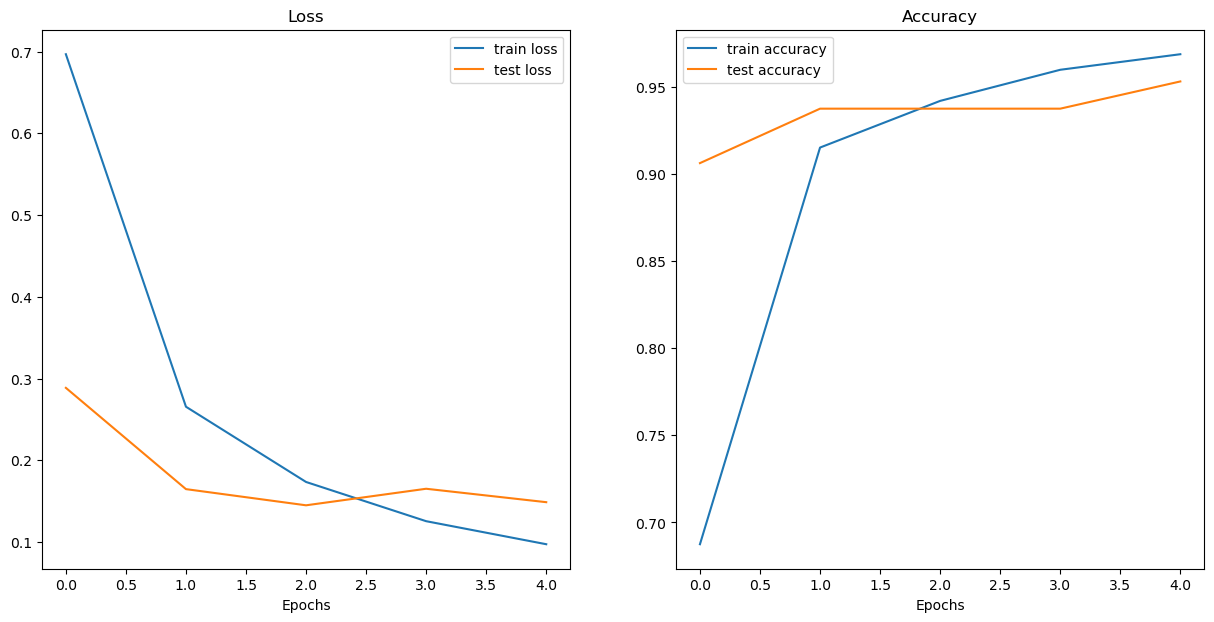

In [19]:
utils.plot_loss_curves(results)

In [21]:
utils.save_model(pretrained_vit, 'models', model_name='Pretrained_Vit.pt')

[INFO] Saving model to: models/Pretrained_Vit.pt
